In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
df = pd.read_csv("Churn_Modelling.csv", index_col='RowNumber')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

In [5]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df = pd.get_dummies(data=df, prefix='Geo', columns=['Geography'])
df[['Geo_France', 'Geo_Germany', 'Geo_Spain']] = df[['Geo_France', 'Geo_Germany', 'Geo_Spain']].astype(int)

In [7]:
df = df.replace(to_replace={'Gender': {'Female': 1,'Male':0}})

In [8]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_France,Geo_Germany,Geo_Spain
RowNumber,,,,,,,,,,,,,
1,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
2,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
3,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
4,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
5,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


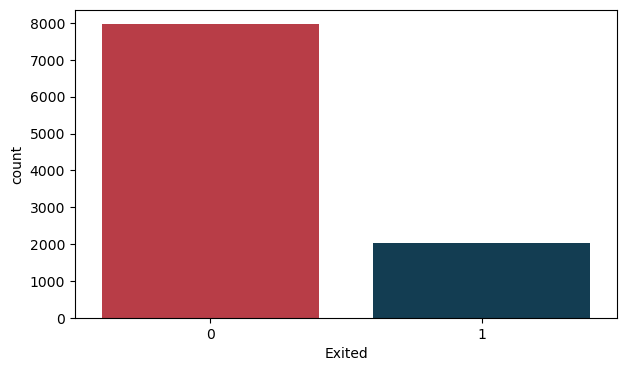

In [9]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x=df.Exited, palette=['#cc2936',"#08415c"])
plt.show()

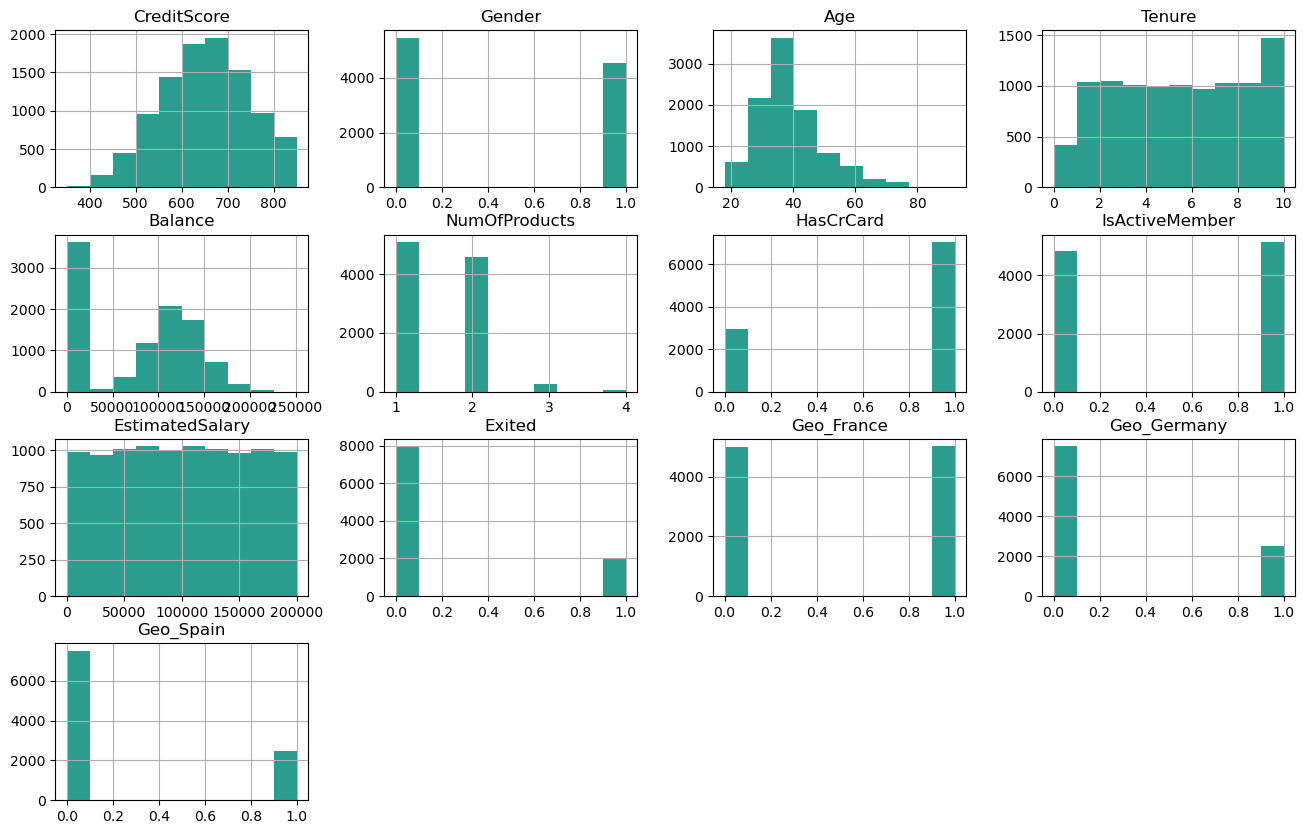

In [10]:
df.hist(figsize=(16,10), color='#2a9d8f')
plt.title("Distribution of features")
plt.show()

<Axes: >

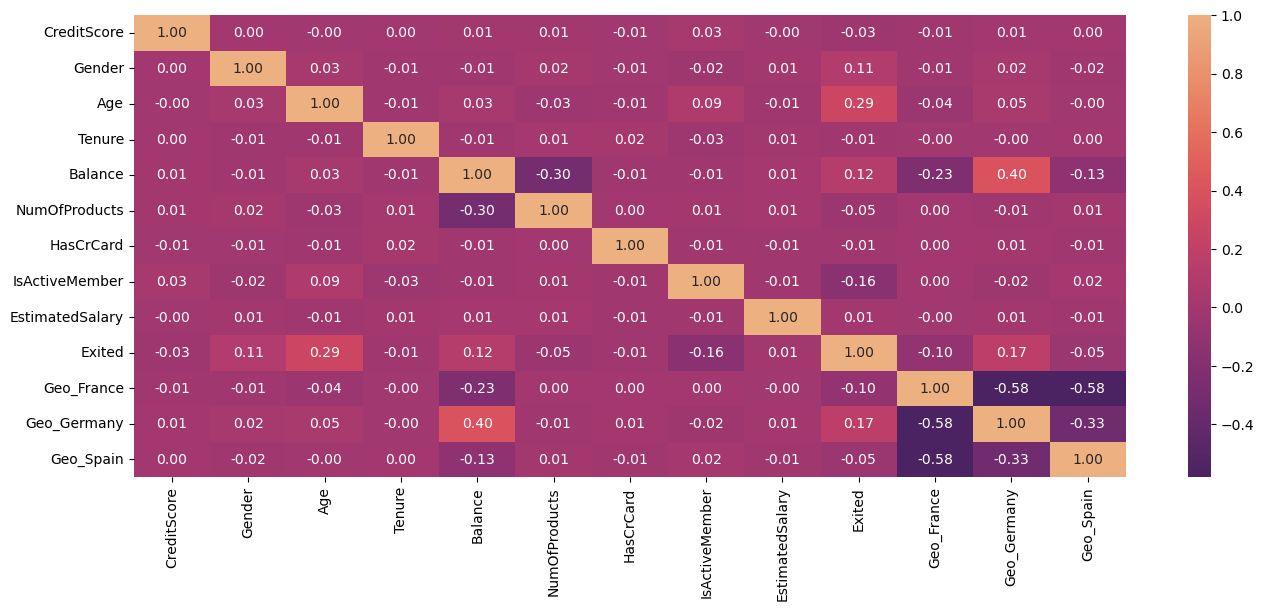

In [11]:
plt.figure(figsize=(16,6))
sns.heatmap(df.corr(), annot=True, fmt='0.2f', cmap='flare_r')

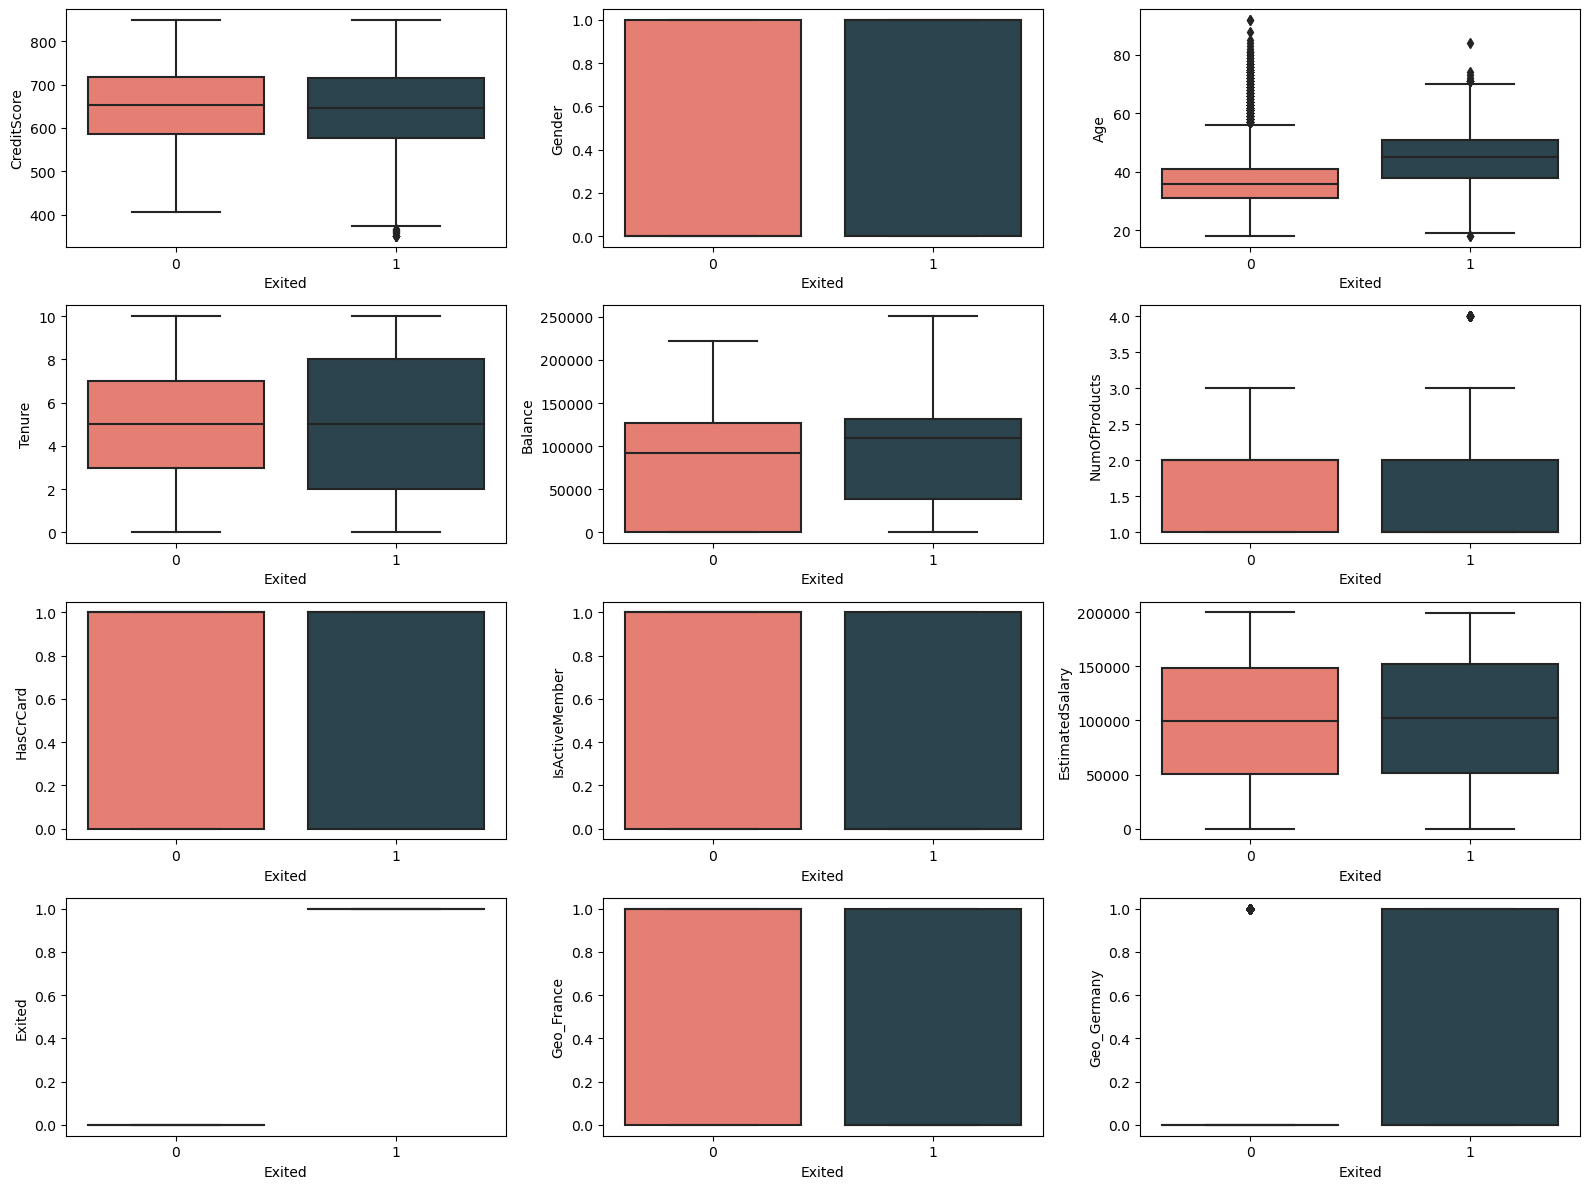

In [12]:
fig,ax = plt.subplots(nrows = 4, ncols=3, figsize=(16,12))
row = 0
col = 0
for i in range(len(df.columns) -1):
    if col > 2:
        row += 1
        col = 0
    axes = ax[row,col]
    sns.boxplot(x = df['Exited'], y = df[df.columns[i]],ax = axes, palette=['#f87060','#264653'])
    col += 1
plt.tight_layout()
plt.show()

In [13]:
x = df.drop(['Exited'], axis=1)
y = df['Exited']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [15]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [16]:
model = Sequential()
model.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
model.add(Dense(units = 150, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 200, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [17]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 200)               30200     
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 46851 (183.01 KB)
Trainable params: 46851 (183.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
EPOCHS = 100
BATCH_SIZE  = 64

l1 = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 0)

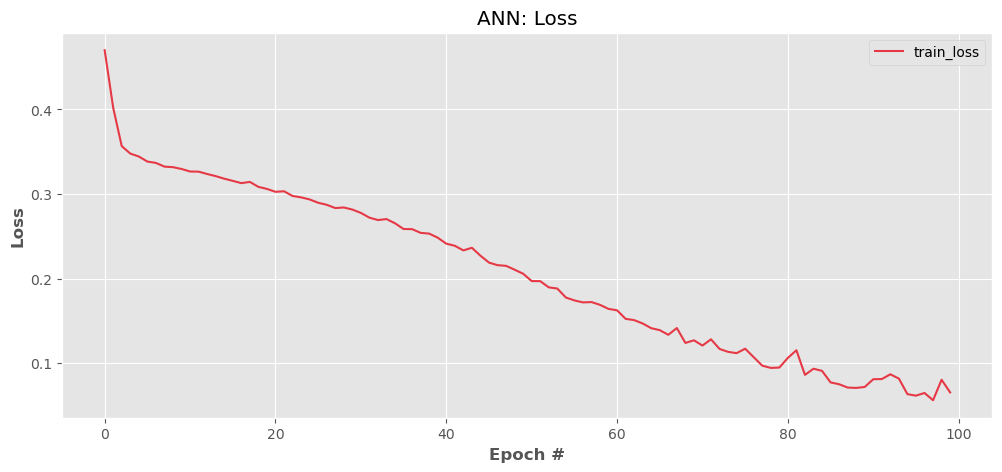

In [20]:
# validation loss
plt.style.use("ggplot")
plt.figure(figsize = (12,5))
plt.plot(np.arange(0, EPOCHS), l1.history["loss"], label="train_loss", color='#e63946')
plt.title("ANN: Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

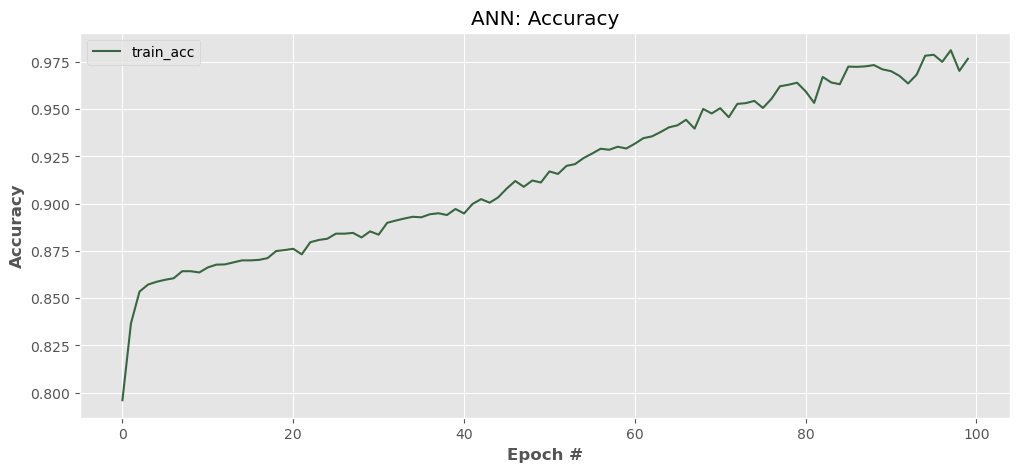

In [21]:
# validation accuracy
plt.style.use("ggplot")
plt.figure(figsize = (12,5))
plt.plot(np.arange(0, EPOCHS), l1.history["accuracy"], label="train_acc", color='#386641')
plt.title("ANN: Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

In [22]:
score, acc = model.evaluate(x_train, y_train)
print('Train score:', score)
print('Train accuracy:', acc)

235/235 [==============================] - 0s 353us/step - loss: 0.0679 - accuracy: 0.9773
Train score: 0.06793521344661713
Train accuracy: 0.9773333072662354


In [23]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)
score, acc = model.evaluate(x_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

79/79 [==============================] - 0s 358us/step - loss: 1.1587 - accuracy: 0.8076
Test score: 1.1586744785308838
Test accuracy: 0.8076000213623047


In [24]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 14.722222222222216, 'Predicted label')

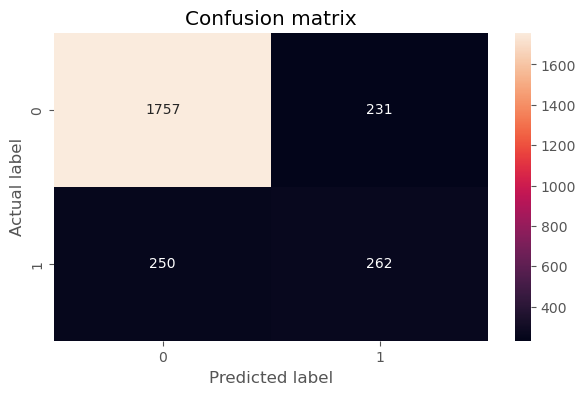

In [25]:
plt.figure(figsize=(7,4))
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1988
           1       0.53      0.51      0.52       512

    accuracy                           0.81      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.80      0.81      0.81      2500



79/79 [==============================] - 0s 323us/step


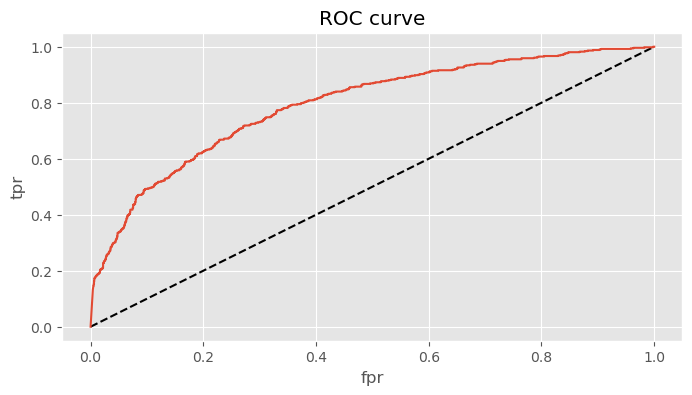

In [27]:
plt.figure(figsize=(8,4))
y_pred_prob = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [28]:
print(roc_auc_score(y_test,y_pred_prob))

0.7924578722334005


In [29]:
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 64, epochs = 50,verbose=0)
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
mean = accuracies.mean()
variance = accuracies.std()

In [30]:
print('Mean accuracy score: {}'.format(round(mean*100,2)))
print('Standard Deviation of accuracy score: {}'.format(round(variance,4)))

Mean accuracy score: 84.16
Standard Deviation of accuracy score: 0.0091


In [31]:
# Improving the ANN
classifier = Sequential()
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
classifier.add(Dropout(rate = 0.1))
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = 0.1))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(x_train, y_train, batch_size = 64, epochs = 50,verbose = 0)

In [32]:
score, acc = classifier.evaluate(x_train, y_train)
print('Train score:', score)
print('Train accuracy:', acc)

y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)
score, acc = classifier.evaluate(x_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

cm = confusion_matrix(y_test, y_pred)

235/235 [==============================] - 0s 281us/step - loss: 0.4092 - accuracy: 0.8315
Train score: 0.40922099351882935
Train accuracy: 0.8314666748046875
79/79 [==============================] - 0s 288us/step - loss: 0.4141 - accuracy: 0.8364
Test score: 0.41407108306884766
Test accuracy: 0.8363999724388123


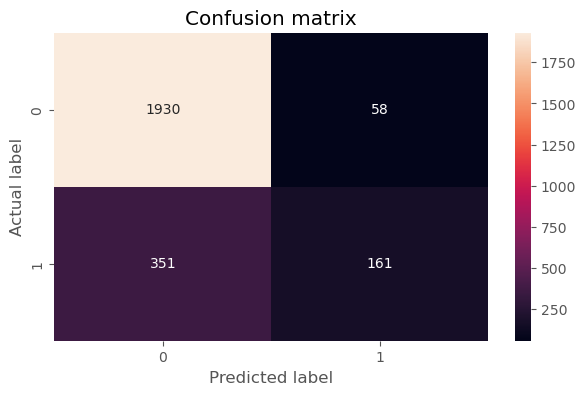

In [33]:
plt.figure(figsize=(7,4))
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1988
           1       0.74      0.31      0.44       512

    accuracy                           0.84      2500
   macro avg       0.79      0.64      0.67      2500
weighted avg       0.82      0.84      0.81      2500



79/79 [==============================] - 0s 318us/step


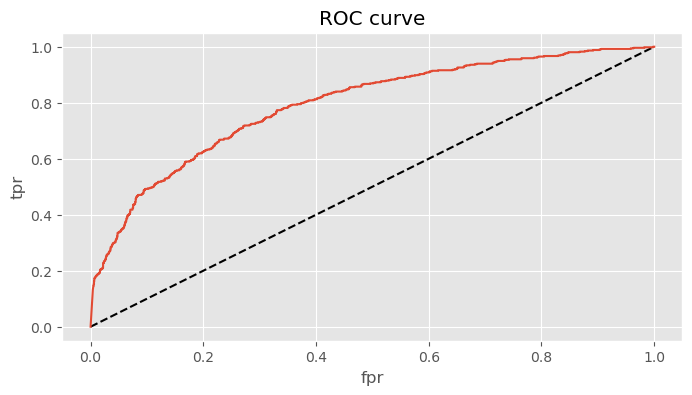

In [35]:
plt.figure(figsize=(8,4))
y_pred_prob = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [36]:
print(roc_auc_score(y_test,y_pred_prob))

0.7924578722334005


In [37]:
def build_classifier(optimizer='adam'):
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
    
classifier = KerasClassifier(build_fn = build_classifier,verbose=0)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 200],
              'optimizer': ['adam', 'rmsprop']}

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

grid_search = grid_search.fit(x_train, y_train,verbose = 0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [38]:
print('Best Parameters after tuning: {}'.format(best_parameters))
print('Best Accuracy after tuning: {}'.format(best_accuracy))

Best Parameters after tuning: {'batch_size': 25, 'epochs': 200, 'optimizer': 'adam'}
Best Accuracy after tuning: 0.8496
